# `Individual` models

In [1]:
# Sconda conda activate tensorflow2; cd /mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/deeplift_analysis/; python

In [2]:
%load_ext lab_black

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
)

import os

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from tensorflow.keras.initializers import GlorotUniform

from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras import backend as K

import sys
import pkg_resources

/scratch/ipykernel_3775365/193332328.py:28: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Declare some constants

In [4]:
out_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/fcdnn_keras"
keras_model_json = "./models/clean_samples_model.json"
keras_model_weights = "./models/clean_samples_weights.h5"
OutputLayer = "sigmoid"
data_dir = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B"
sample_names = pd.read_csv(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/filtered_files_surnames.csv",
    header=None,
)[7].tolist()

### Loading Datasets

In [5]:
def load_dataset(data_dir, sample, print_shape: bool = False):
    preffix = os.path.join(data_dir, sample)
    X = np.load(preffix + "_Train_X.npz")["arr_0"].T
    Y = np.load(preffix + "_Train_Y.npz")["arr_0"].T
    X_dev = np.load(preffix + "_Dev_X.npz")["arr_0"].T
    Y_dev = np.load(preffix + "_Dev_Y.npz")["arr_0"].T
    X_test = np.load(preffix + "_Test_X.npz")["arr_0"].T
    Y_test = np.load(preffix + "_Test_Y.npz")["arr_0"].T
    if print_shape:
        print(
            f"""
X_train shape: {X.shape}
Y_train shape: {Y.shape}

X_dev shape: {X_dev.shape}
Y_dev shape: {Y_dev.shape}

X_test shape: {X_test.shape}
Y_test shape: {Y_test.shape}
"""
        )
    return X, Y, X_dev, Y_dev, X_test, Y_test

## Sequential-style FCDNN

### Function to remove layer that is causing issues:

In [6]:
# Load the original JSON data
def json_remove_input_layer(json_file):
    # Read json
    with open(json_file, "r") as file:
        data = json.load(file)
        file.close()
    # Check if it has the problem and delete
    if (
        data["config"]["layers"]
        and data["config"]["layers"][0]["class_name"] == "InputLayer"
    ):
        del data["config"]["layers"][0]
        print("deleted 'InputLayer' layer config")
        # Save the modified data back to a new JSON file
        with open(json_file, "w") as file:
            json.dump(data, file, indent=4)
            file.close()
    else:
        print("Model does not contain 'InputLayer' in layer config")


# Remove the first layer from the 'layers' list within the 'config' key

### Function to make Keras model

In [7]:
# Make this a function to get a cleaner code:
def make_keras_model(X):
    keras_model = Sequential()
    keras_model.add(
        Dense(
            200,
            activation="relu",
            name="1",
            input_dim=X.shape[1],
            kernel_initializer=GlorotUniform(),
        )
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(100, activation="relu", name="2", kernel_initializer=GlorotUniform())
    )
    keras_model.add(Dropout(0.15))
    keras_model.add(
        Dense(50, activation="relu", name="3", kernel_initializer=GlorotUniform())
    )
    keras_model.add(
        Dense(
            1, activation="sigmoid", name="Output", kernel_initializer=GlorotUniform()
        )
    )
    keras_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return keras_model

### Function to test model

In [8]:
def test_and_auc(
    keras_model,
    X_test,
    Y_test,
    save_prob: bool = False,
    prin_auc_plot: bool = True,
    save_auc_plot: bool = True,
    sample_name="Clean Samples",
    out_dir: str = "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/fcdnn_keras",
):
    sample_file_name = sample_name.lower().replace(" ", "_")
    out_file_plot = os.path.join(
        out_dir, "figures", f"roc_curve_{sample_file_name}.png"
    )
    out_file_prob = os.path.join(out_dir, "predictions", f"test_{sample_file_name}")
    ProbableValues = keras_model.predict(X_test)
    preds = keras_model.evaluate(x=X_test, y=Y_test)
    Obs = pd.Series(Y_test.flatten().astype(int))
    Pred = pd.Series(ProbableValues.round().flatten().astype(int))
    Prob = pd.Series(ProbableValues.flatten().astype(float))
    Side2Prob = pd.concat([Obs, Pred, Prob], axis=1)
    Side2Prob.columns = ["Observed", "Predicted", "Probability"]
    if save_prob:
        Side2Prob.to_feather(out_file_prob + ".feather")
        Side2Prob.to_csv(out_file_prob + ".csv", index=False)

    fpr, tpr, _ = roc_curve(Obs, Prob)
    auc_score = roc_auc_score(Obs, Prob)

    print(
        """
%s
Accuracy:    %.4f
Precision:   %.4f
Recall:      %.4f
F1 score:    %.4f
AUC Score:   %.4f
"""
        % (
            sample_name,
            preds[1],
            precision_score(Obs, Pred),
            recall_score(Obs, Pred),
            f1_score(Obs, Pred),
            auc_score,
        )
    )
    font_name = "Nimbus Roman"
    # downsample points to plot if too large
    num_points = min(len(tpr), 1000)
    fpr_interp = np.linspace(0, 1, num_points)
    tpr_interp = np.interp(fpr_interp, fpr, tpr)
    plt.rcParams["font.family"] = "Nimbus Roman"

    # Setting the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create the plot with Seaborn
    plt.figure(figsize=(8, 6))
    sns.lineplot(
        x=fpr_interp,
        y=tpr_interp,
        label=f"Model (AUC = {auc_score:.2f})",
        linewidth=2,
    )
    ax = sns.lineplot(
        x=[0, 1],
        y=[0, 1],
        linestyle="--",
        label="No learning",
        color="tab:gray",
    )

    # Customizing the plot to make it more suitable for publication
    title_fontsize = 16 * 1.3  # 2x the base size for labels
    label_fontsize = 16 * 1.5  # 2x the base size for labels
    tick_fontsize = 12 * 2  # 2x the base size for ticks
    ax.set_title(
        f"ROC Curve: {sample_name}", fontsize=title_fontsize, fontname=font_name
    )
    ax.set_xlabel(
        "False Positive Rate (FPR)", fontsize=label_fontsize, fontname=font_name
    )
    ax.set_ylabel(
        "True Positive Rate (TPR)", fontsize=label_fontsize, fontname=font_name
    )
    plt.xticks(fontsize=tick_fontsize, fontname=font_name)
    plt.yticks(fontsize=tick_fontsize, fontname=font_name)
    plt.legend(loc="best", fontsize=14)
    plt.tight_layout()
    if prin_auc_plot:
        # Show the plot
        plt.show()
    if save_auc_plot:
        # Save the plot
        plt.savefig(out_file_plot, dpi=300)
    plt.close()

    return Side2Prob

In [31]:
def get_auc_f1(
    keras_model,
    X_test,
    Y_test,
):

    ProbableValues = keras_model.predict(X_test)
    Obs = pd.Series(Y_test.flatten().astype(int))
    Prob = pd.Series(ProbableValues.flatten().astype(float))
    Pred = pd.Series(ProbableValues.round().flatten().astype(int))
    auc_score = round(roc_auc_score(Obs, Prob), 4)
    f1 = round(f1_score(Obs, Pred), 4)

    return auc_score, f1

### Train Models

In [8]:
out_dir

'/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/results/fcdnn_keras'

In [9]:
for i, sample in enumerate(sample_names):
    # set outputs:
    keras_model_json = os.path.join(out_dir, "models", sample + "_model.json")
    keras_model_weights = os.path.join(out_dir, "models", sample + "_weights.h5")
    # clean session
    K.clear_session()
    # load data:
    X, Y, X_dev, Y_dev, X_test, Y_test = load_dataset(data_dir, sample)
    # define the keras model
    clean_data_model = make_keras_model(X)
    clean_data_model.fit(x=X, y=Y, batch_size=1024, epochs=40)
    preds = clean_data_model.evaluate(x=X_dev, y=Y_dev)
    # serialize model to JSON
    model_json = clean_data_model.to_json()
    with open(keras_model_json, "w") as json_file:
        json_file.write(model_json)
        json_file.close()
    # Load back for formatting
    json_remove_input_layer(keras_model_json)
    # serialize weights to HDF5
    clean_data_model.save_weights(keras_model_weights)

### Plot metrics

In [30]:
for i, sample in enumerate(sample_names):
    K.clear_session()
    # set outputs:
    keras_model_json = os.path.join(out_dir, "models", sample + "_model.json")
    keras_model_weights = os.path.join(out_dir, "models", sample + "_weights.h5")
    # clean session
    K.clear_session()
    # load data:
    _, _, _, _, X_test, Y_test = load_dataset(data_dir, sample)
    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    keras_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    _ = test_and_auc(
        keras_model,
        X_test,
        Y_test,
        prin_auc_plot=False,
        save_auc_plot=True,
        save_prob=True,
        sample_name=sample,
        out_dir=out_dir,
    )


mm10_Bcell_Activated_24_Rep1
Accuracy:    0.7743
Precision:   0.7868
Recall:      0.8627
F1 score:    0.8230
AUC Score:   0.9006


mm10_Bcell_Activated_48_Rep1
Accuracy:    0.7743
Precision:   0.8093
Recall:      0.8754
F1 score:    0.8411
AUC Score:   0.9099


mm10_Bcell_Activated_72_Rep1
Accuracy:    0.7743
Precision:   0.7902
Recall:      0.8618
F1 score:    0.8244
AUC Score:   0.8941


mm10_Bcell_Resting_Rep1
Accuracy:    0.7743
Precision:   0.7978
Recall:      0.8537
F1 score:    0.8248
AUC Score:   0.9089


mm10_Bergmann_Glia_Rep2
Accuracy:    0.7743
Precision:   0.7448
Recall:      0.8382
F1 score:    0.7888
AUC Score:   0.8366


mm10_CD4_Naive_Tcell_Rep2
Accuracy:    0.7743
Precision:   0.8513
Recall:      0.8627
F1 score:    0.8569
AUC Score:   0.9336


mm10_CD4_SinglePositive_Tcell_Rep1
Accuracy:    0.7743
Precision:   0.8219
Recall:      0.8255
F1 score:    0.8237
AUC Score:   0.9005


mm10_CD8_Naive_Tcell_Rep2
Accuracy:    0.7743
Precision:   0.8257
Recall:      0.8910
F1 

## Get AUC distribution for main table

In [32]:
auc_results = []
f1_results = []
for i, sample in enumerate(sample_names):
    K.clear_session()
    # set outputs:
    keras_model_json = os.path.join(out_dir, "models", sample + "_model.json")
    keras_model_weights = os.path.join(out_dir, "models", sample + "_weights.h5")
    # clean session
    K.clear_session()
    # load data:
    _, _, _, _, X_test, Y_test = load_dataset(data_dir, sample)
    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    keras_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    auc, f1 = get_auc_f1(keras_model, X_test, Y_test)
    auc_results.append(auc)
    f1_results.append(f1)

In [33]:
round(pd.DataFrame(auc_results).describe(), 4)

,0
count,49.0000
mean,0.8603
std,0.0420
min,0.7453
25%,0.8380
50%,0.8546
75%,0.8941
max,0.9369


In [34]:
round(pd.DataFrame(f1_results).describe(), 4)

,0
count,49.0000
mean,0.7931
std,0.0385
min,0.6571
25%,0.7746
50%,0.7949
75%,0.8221
max,0.8571


In [35]:
print("\n".join(map(str, auc_results)))

0.9006
0.9099
0.8941
0.9089
0.8366
0.9336
0.9005
0.9369
0.9283
0.7983
0.766
0.9087
0.8861
0.8368
0.8135
0.8285
0.8497
0.838
0.8482
0.8585
0.8743
0.8501
0.8509
0.8456
0.863
0.8405
0.8794
0.8264
0.8357
0.8956
0.7976
0.8574
0.842
0.8049
0.8575
0.8521
0.8446
0.9178
0.8655
0.8634
0.9224
0.7453
0.847
0.8546
0.8469
0.9302
0.8283
0.8715
0.8645


In [36]:
print("\n".join(map(str, f1_results)))

0.823
0.8411
0.8244
0.8248
0.7888
0.8569
0.8237
0.8571
0.8526
0.7449
0.7071
0.8339
0.8017
0.7722
0.7676
0.7493
0.7972
0.7881
0.7933
0.8
0.7997
0.7835
0.778
0.774
0.7775
0.7818
0.8145
0.7456
0.7746
0.8221
0.7335
0.7868
0.7772
0.753
0.8077
0.7969
0.76
0.8394
0.8096
0.8067
0.838
0.6571
0.7927
0.7897
0.7955
0.8497
0.7705
0.8037
0.7949


# Print packages used

In [31]:
def get_imported_packages_with_versions():
    imported_packages = set(
        [module.split(".")[0] for module in sys.modules.keys() if module.split(".")[0]]
    )
    imported_packages_with_versions = {}

    for pkg in imported_packages:
        try:
            version = pkg_resources.get_distribution(pkg).version
            imported_packages_with_versions[pkg] = version
        except (
            pkg_resources.DistributionNotFound,
            pkg_resources.ExtractionError,
            pkg_resources.VersionConflict,
            Exception,
        ):
            # Skip packages that cause issues
            pass

    return imported_packages_with_versions


imported_packages_with_versions = get_imported_packages_with_versions()

# Print the package names and their versions
for pkg, version in imported_packages_with_versions.items():
    print(f"{pkg}: {version}")

kiwisolver: 1.4.5
astunparse: 1.6.3
wrapt: 1.16.0
brotli: 1.1.0
backcall: 0.2.0
pyarrow: 3.0.0
jedi: 0.19.1
pytz: 2024.1
jupyter_client: 8.6.0
urllib3: 2.2.0
zipp: 3.17.0
black: 24.1.1
wcwidth: 0.2.13
termcolor: 2.4.0
debugpy: 1.8.1
charset_normalizer: 3.3.2
six: 1.16.0
threadpoolctl: 3.2.0
matplotlib: 3.5.1
pure_eval: 0.2.2
cycler: 0.12.1
importlib_metadata: 7.0.1
h5py: 2.10.0
gast: 0.3.3
traitlets: 5.14.1
tensorflow: 2.4.0
pygments: 2.17.2
keras_preprocessing: 1.1.2
numpy: 1.19.1
pandas: 1.3.5
mypy_extensions: 1.0.0
certifi: 2024.2.2
asttokens: 2.4.1
executing: 2.0.1
tomli: 2.0.1
tornado: 6.4
scipy: 1.9.3
cffi: 1.16.0
ptyprocess: 0.7.0
jupyter_core: 5.7.1
joblib: 1.3.2
psutil: 5.9.8
pathspec: 0.12.1
platformdirs: 4.2.0
seaborn: 0.12.2
stack_data: 0.6.2
pyparsing: 3.1.1
opt_einsum: 3.3.0
matplotlib_inline: 0.1.6
click: 8.1.7
setuptools: 69.0.3
decorator: 5.1.1
ipykernel: 6.28.0
tensorboard: 2.4.1
prompt_toolkit: 3.0.42
requests: 2.31.0
keras: 2.4.3
pickleshare: 0.7.5
parso: 0.8.3
idna

# Train 1 model excesively

In [10]:
i = 2
sample = sample_names[i]
epochs = 1000
print(sample)
# set outputs:
keras_model_json = os.path.join(
    out_dir, "models", sample + f"_{epochs}_epochs_model.json"
)
keras_model_weights = os.path.join(
    out_dir, "models", sample + f"_{epochs}_epochs_weights.h5"
)
# clean session
K.clear_session()
# load data:
X, Y, X_dev, Y_dev, X_test, Y_test = load_dataset(data_dir, sample)
# define the keras model
clean_data_model = make_keras_model(X)
history = clean_data_model.fit(x=X, y=Y, batch_size=1024, epochs=epochs)
preds = clean_data_model.evaluate(x=X_dev, y=Y_dev)
# serialize model to JSON
model_json = clean_data_model.to_json()
with open(keras_model_json, "w") as json_file:
    json_file.write(model_json)
    json_file.close()
# Load back for formatting
json_remove_input_layer(keras_model_json)
# serialize weights to HDF5
clean_data_model.save_weights(keras_model_weights)

mm10_Bcell_Activated_72_Rep1


2024-02-19 16:59:11.898870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:59:11.994265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-19 16:59:12.006764: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/1000
19/19 [==============================] - 0s 5ms/step - loss: 1.2700 - accuracy: 0.4968
Epoch 2/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.7380 - accuracy: 0.6535
Epoch 3/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.5952 - accuracy: 0.7261
Epoch 4/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.5590 - accuracy: 0.7449
Epoch 5/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.5210 - accuracy: 0.7624
Epoch 6/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.5041 - accuracy: 0.7671
Epoch 7/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.4977 - accuracy: 0.7775
Epoch 8/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.4859 - accuracy: 0.7778
Epoch 9/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.4736 - accuracy: 0.7824
Epoch 10/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.4701 - accuracy: 0.7840

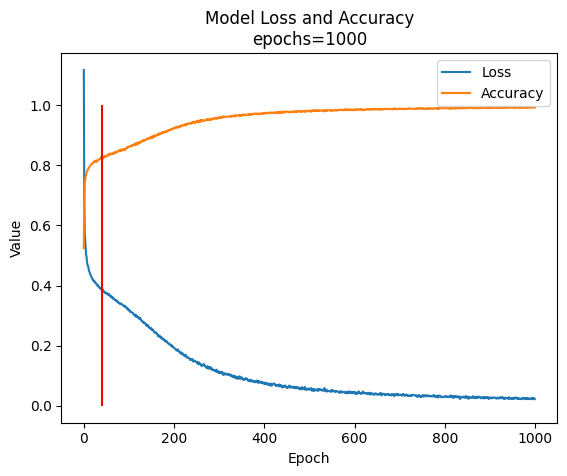

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Loss")
if "accuracy" in history.history:
    plt.plot(history.history["accuracy"], label="Accuracy")
elif "acc" in history.history:  # For older versions of Keras
    plt.plot(history.history["acc"], label="Accuracy")

plt.title(f"Model Loss and Accuracy\nepochs={epochs}")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.vlines(x=40, ymin=0.0, ymax=1.0, colors="red")
plt.legend()
plt.show()


mm10_Bcell_Activated_72_Rep1
Accuracy:    0.8146
Precision:   0.7577
Recall:      0.8410
F1 score:    0.7972
AUC Score:   0.8602



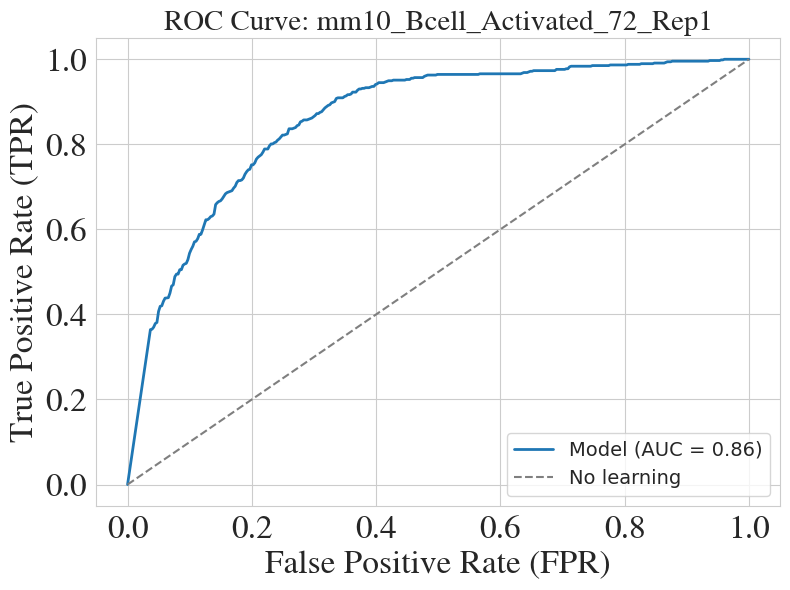


mm10_Bcell_Activated_72_Rep1
Accuracy:    0.8146
Precision:   0.7902
Recall:      0.8618
F1 score:    0.8244
AUC Score:   0.8941



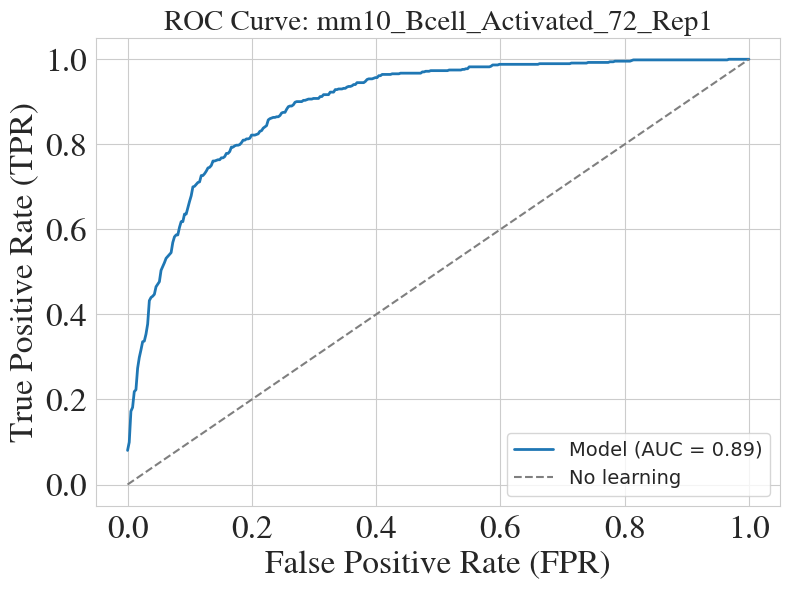

In [42]:
i = 2
sample = sample_names[i]
epochs = 3000
_, _, _, _, X_test, Y_test = load_dataset(data_dir, sample)

K.clear_session()
# set outputs:
keras_model_json = os.path.join(
    out_dir, "models", sample + f"_{epochs}_epochs_model.json"
)
keras_model_weights = os.path.join(
    out_dir, "models", sample + f"_{epochs}_epochs_weights.h5"
)
# clean session
K.clear_session()
# load data:
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
_ = test_and_auc(
    keras_model,
    X_test,
    Y_test,
    prin_auc_plot=True,
    save_auc_plot=False,
    save_prob=False,
    sample_name=sample,
    out_dir=out_dir,
)

K.clear_session()
# set outputs:
keras_model_json = os.path.join(out_dir, "models", sample + "_model.json")
keras_model_weights = os.path.join(out_dir, "models", sample + "_weights.h5")
# clean session
K.clear_session()
# load data:
keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)
keras_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
_ = test_and_auc(
    keras_model,
    X_test,
    Y_test,
    prin_auc_plot=True,
    save_auc_plot=False,
    save_prob=False,
    sample_name=sample,
    out_dir=out_dir,
)

What we see is that the trained e=3000 overfitted the training dev set but did good on the test set.\
However, it was not superior to the model trained a significant amount less of epochs (e=40)